# Module 8

## Video 36: Predictive Modelling I
**Python for the Energy Industry**

When working with time series data, we may want to predict the likely future values of the data. One common way of doing this is to use an autoregressive integrated moving average [(ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model. That is the subject of this lesson.

We will work with data giving the daily global floating storage of crude:

In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v

# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

In [3]:
# Find crude ID
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

search_result = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_products=crude,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    # Filter for cargo in floating storage
    filter_activity="storing_state",
    # Only get floating storage that lasted longer than 21 days
    timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 14,
)

df_floating_storage = search_result.to_df()
df_floating_storage = df_floating_storage.rename(columns = {'key': 'date', 'value': 'quantity'})[['date','quantity']]

Let's start by taking a look at the data:

<AxesSubplot:xlabel='date'>

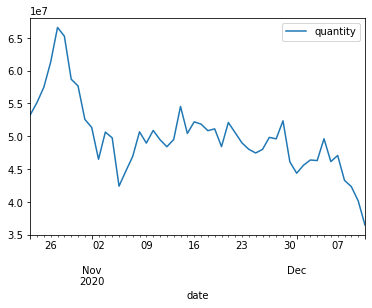

In [4]:
df_floating_storage.plot(x='date',y='quantity')

In the next lesson we will discuss choosing an appropriate ARIMA model. For now, we will start with a first-order autoregressive model, ARIMA(1,0,0). We will fit this onto the first 6 weeks of data, and use the 7th week to test the model's predictions:

In [5]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(df_floating_storage['quantity'].head(42),order=(1,0,0))
res = arima.fit()

We can get a summary of our fit:

In [6]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                   42
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -685.209
Date:                Fri, 11 Dec 2020   AIC                           1376.418
Time:                        16:21:57   BIC                           1381.631
Sample:                             0   HQIC                          1378.329
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.112e+07   9.75e-10   5.24e+16      0.000    5.11e+07    5.11e+07
ar.L1          0.8094      0.078     10.433      0.000       0.657       0.961
sigma2      8.615e+12   1.22e-15   7.04e+27      0.000    8.61e+12    8.61e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.66   Prob(JB):                         0.83
Heteroskedasticity (H):               0.35   Skew:                            -0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+37. Standard errors may be unstable.
"""

We will start by simply getting the predictions of the model over the time range on which it was fitted. We do this as follows:

<AxesSubplot:xlabel='date'>

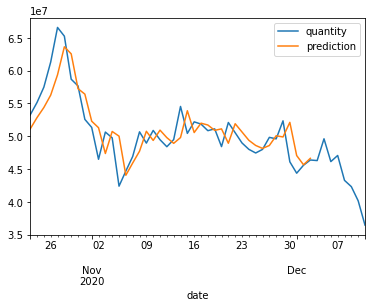

In [7]:
pred = res.get_prediction()
df_floating_storage['prediction'] = pred.predicted_mean
df_floating_storage.plot(x='date',y=['quantity','prediction'])

Let's extend our prediction to the week following the fitted region:

In [8]:
pred = res.get_prediction(end=49)
df_floating_storage['prediction'] = pred.predicted_mean

We will also add to our plot the 95% confidence region. We can put these values into our dataframe as follows:

In [9]:
df_floating_storage['lower'] = pred.conf_int()['lower quantity']
df_floating_storage['upper'] = pred.conf_int()['upper quantity']

We use the `fill_between` function to shade the confidence region in green, with 10% opacity. 

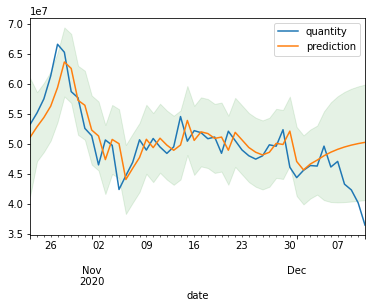

In [10]:
ax = df_floating_storage.plot(x='date',y=['quantity','prediction'])
ax.fill_between(df_floating_storage['date'].values,df_floating_storage['lower'],df_floating_storage['upper'],color='g',alpha=.1)

The true values do indeed lie within the confidence interval. We can also check whether our model is biased by looking at a plot of the residuals:

<AxesSubplot:ylabel='Density'>

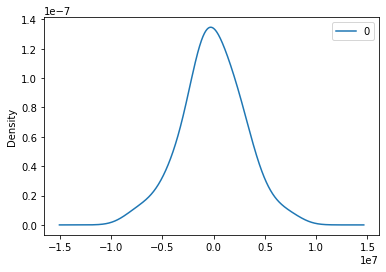

In [11]:
pd.DataFrame(res.resid).plot(kind='kde')

Since this looks roughly normal and is not strongly skewed, our model is not particularly biased.

### Exercise

Have a go at repeating this analysis (fitting an ARIMA(1,0,0) model, predicting, and looking at residuals) for a different time series, e.g. US crude exports.